In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import category_encoders as ce 
from pathlib import Path

# for preprocessing the data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
# the model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.utils import class_weight

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

import itertools

from scipy.stats import ks_2samp
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
pd.set_option('display.max_columns', 100)
import warnings

warnings.filterwarnings('ignore')

!pip install category_encoders

In [2]:
# Required paths
train_values_p = "train_values.csv"
train_labels_p = "train_labels.csv"
test_values_p ="test_values.csv"
# State
random_token = 1771

def submission(y_pred):
    submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
    my_submission = pd.DataFrame(data=y_pred,
                                 columns=submission_format.columns,
                                 index=submission_format.index)
    my_submission.damage_grade = my_submission.damage_grade.astype(int)
    my_submission.to_csv('submission.csv')

In [3]:
train_values = pd.read_csv(train_values_p, index_col='building_id')
train_labels = pd.read_csv(train_labels_p, index_col='building_id')
test_values = pd.read_csv(test_values_p, index_col='building_id')
train_index = train_values.index
test_index = test_values.index

In [4]:
# We should do the same preprocessing on both train and test values
test_and_train_values = pd.concat([train_values,test_values])
print("Train:",test_and_train_values.loc[train_index].shape)
print("Test:",test_and_train_values.loc[test_index].shape)
# Concat the damage grades
test_and_train = test_and_train_values.join(train_labels)

Train: (260601, 38)
Test: (86868, 38)


In [5]:
print("Train with damage grade:",test_and_train.loc[train_index].shape)

Train with damage grade: (260601, 39)


In [6]:
test_and_train.dtypes

geo_level_1_id                              int64
geo_level_2_id                              int64
geo_level_3_id                              int64
count_floors_pre_eq                         int64
age                                         int64
area_percentage                             int64
height_percentage                           int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64
has_superstructure_cement_mortar_stone      int64
has_superstructure_mud_mortar_brick         int64
has_superstructure_cement_mortar_brick      int64


In [7]:
secondary_uses = [
'has_secondary_use',
'has_secondary_use_agriculture',
'has_secondary_use_hotel',
'has_secondary_use_rental',
'has_secondary_use_institution',
'has_secondary_use_school',
'has_secondary_use_industry',
'has_secondary_use_health_post',
'has_secondary_use_gov_office',
'has_secondary_use_use_police',
'has_secondary_use_other'
]

structure = [
'has_superstructure_adobe_mud',
'has_superstructure_mud_mortar_stone',
'has_superstructure_stone_flag',
'has_superstructure_cement_mortar_stone',
'has_superstructure_mud_mortar_brick',
'has_superstructure_cement_mortar_brick',
'has_superstructure_timber',
'has_superstructure_bamboo',
'has_superstructure_rc_non_engineered',
'has_superstructure_rc_engineered',
'has_superstructure_other'
]

train = test_and_train.copy()

In [8]:
# There are similarities in damage between 
#the mortar types (mud/cement) and the reinforced concrete types (non-eng, engineered) 
#so for the sake of our geoid indicator we'll group them
test_and_train['mud'] = test_and_train['has_superstructure_adobe_mud'] | test_and_train['has_superstructure_mud_mortar_stone'] | test_and_train['has_superstructure_mud_mortar_brick']
test_and_train['cement'] = test_and_train['has_superstructure_cement_mortar_stone'] | test_and_train['has_superstructure_cement_mortar_brick'] 
test_and_train['concrete'] = test_and_train['has_superstructure_rc_non_engineered'] | test_and_train['has_superstructure_rc_engineered'] 
test_and_train['natural'] = test_and_train['has_superstructure_timber'] | test_and_train['has_superstructure_bamboo'] 

test_and_train['n_struc_types'] = test_and_train['mud'] + test_and_train['cement'] + test_and_train['concrete'] + test_and_train['natural']

test_and_train['concrete_only'] = (test_and_train['concrete']==True) & (test_and_train['n_struc_types']==1)
test_and_train['cement_only'] = (test_and_train['cement']==True) & (test_and_train['n_struc_types']==1)

# This next one is just a helper column for use later to get averages of damage for each region
test_and_train['no-mud'] = abs(test_and_train['mud']-1)


In [9]:
concrete_only = (test_and_train['concrete']==True) & (test_and_train['n_struc_types']==1)
mud_only = (test_and_train['mud']==True) & (test_and_train['n_struc_types']==1)
cement_only = (test_and_train['cement']==True) & (test_and_train['n_struc_types']==1)
natural_only = (test_and_train['natural']==True) & (test_and_train['n_struc_types']==1)


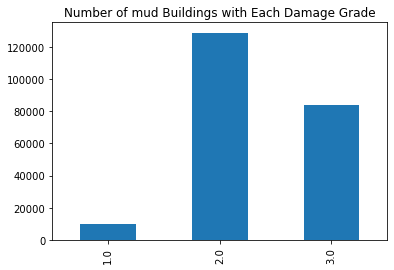

In [10]:
(test_and_train[test_and_train['mud']==True].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of mud Buildings with Each Damage Grade"))

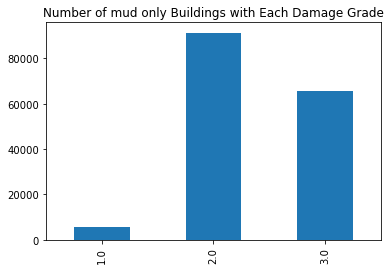

In [11]:

(test_and_train[mud_only].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of mud only Buildings with Each Damage Grade"))


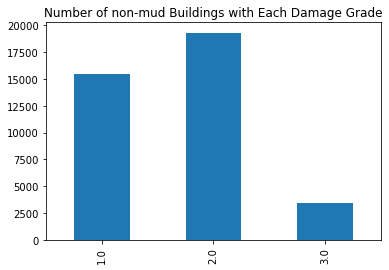

In [12]:
(test_and_train[test_and_train['mud']==False].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of non-mud Buildings with Each Damage Grade"))

In [13]:
struc_types = ['mud','natural','cement','concrete']
combs = []
for i in range(len(struc_types)):
    combs.extend([list(t) for t in [k for k in itertools.combinations(struc_types,i+1)]])
    
combs

[['mud'],
 ['natural'],
 ['cement'],
 ['concrete'],
 ['mud', 'natural'],
 ['mud', 'cement'],
 ['mud', 'concrete'],
 ['natural', 'cement'],
 ['natural', 'concrete'],
 ['cement', 'concrete'],
 ['mud', 'natural', 'cement'],
 ['mud', 'natural', 'concrete'],
 ['mud', 'cement', 'concrete'],
 ['natural', 'cement', 'concrete'],
 ['mud', 'natural', 'cement', 'concrete']]

In [14]:
filters = [test_and_train[t]==True for t in combs[12]]
test_and_train[np.logical_and.reduce(filters)].damage_grade.mean()
np.logical_and.reduce(filters)

array([False, False, False, ..., False, False, False])

In [15]:
### Some geolocations might only be in the test set, so if we are going to build a universal lookup then we need to include test as well so we can get a complete list

In [16]:
### Some geolocations might only be in the test set, so if we are going to build a universal lookup then we need to include test as well so we can get a complete list
geo_lookup = test_and_train[['geo_level_3_id','geo_level_2_id','geo_level_1_id']].groupby(['geo_level_3_id']).first().reset_index()
geo_lookup.head()

,geo_level_3_id,geo_level_2_id,geo_level_1_id
0,0,179,12
1,1,194,15
2,2,657,0
3,3,73,30
4,4,1061,5


In [17]:
test_and_train.loc[train_index].head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,mud,cement,concrete,natural,n_struc_types,concrete_only,cement_only,no-mud
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,0,0,1,False,False,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,0,1,2,False,False,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0


In [18]:
levels = ['1','2','3']
structure_cats = ['mud','no-mud','cement_only', 'concrete_only']


for level in levels:
    print('averaging level',level)
    averages_list = []

    # Work out normalised damage grades for each structure type
    for s in structure_cats:
        s_filter = (test_and_train[s] == 1) & test_and_train.damage_grade.notnull()
        averages = test_and_train[s_filter].groupby('geo_level_'+level+'_id')['damage_grade'].agg({s+level+'_n':'count', 
                                     s+level+'_mean':'mean'})
        col_to_norm = averages[s+level+'_mean']
        averages[s+level+'_mean_norm']=(col_to_norm-col_to_norm.min())/(col_to_norm.max()-col_to_norm.min())
        #print(averages.head(2))
        averages_list.append(averages)

    # Concat the averages into one dataframe
    averages = pd.concat(averages_list, axis=1)
    
    # Now we have those, we can also calculate a weighted average across the structure types for that geoid
    
    norms = [s+level+'_mean_norm' for s in structure_cats]
    weights = [s+level+'_n' for s in structure_cats]

    norms_np = averages[norms].values
    weights_np = averages[weights].values

    # Here, I want to mask out where there are missing values (they are NaNs)
    weights_mask = np.isnan(weights_np)
    
    norms_np = np.ma.masked_array(norms_np, mask=weights_mask)
    weights_np = np.ma.masked_array(weights_np, mask=weights_mask)

    # Calculate the weighted average of the different building type normalised damage 
    wa_norm = np.ma.average(norms_np, weights=weights_np, axis=1)
    wa_norm.fill_value = np.nan
    
    # Now, I also want to mask out any results where the count is less than 3, to reduce data leakage.
    # First, sum up the weights_np values for each row, so we get total # of examples
    sum_of_norms = np.ma.sum(weights_np, axis=1)

    n_min = 3
    sum_of_norms_mask = ((sum_of_norms < n_min) | np.isnan(sum_of_norms))
    
    # Set those values of our results array to be masked 
    wa_norm[sum_of_norms_mask] = np.ma.masked

    # Finally, save the results into the averages array, filling any masked values with na.
    averages['level'+level+'norm_damage'] = wa_norm.filled()

    # Take the same approach on nud & no-mud mean norms, but a bit easier because we just have to create a filter then set the values
    mud_filter = averages['mud'+level+'_n'] < n_min
    averages.loc[mud_filter, 'mud'+level+'_mean_norm'] = np.nan
    
    nomud_filter = averages['no-mud'+level+'_n'] < n_min
    averages.loc[nomud_filter, 'no-mud'+level+'_mean_norm'] = np.nan
    
    #geo_lookup['level'+level+'_wa_norm_damage'] = wa_norm.filled()
    #print(averages.head())
    
    # Add on the columns we want to keep after all of that
    geo_lookup = geo_lookup.merge(averages['level'+level+'norm_damage'].reset_index(), how='left',on='geo_level_'+level+'_id')
    geo_lookup = geo_lookup.merge(averages['mud'+level+'_mean_norm'].reset_index(), how='left',on='geo_level_'+level+'_id')
    geo_lookup = geo_lookup.merge(averages['no-mud'+level+'_mean_norm'].reset_index(), how='left',on='geo_level_'+level+'_id')

print('Done')

averaging level 1
averaging level 2
averaging level 3
Done


In [19]:
empty_level = geo_lookup['level2norm_damage'].isnull()
geo_lookup.loc[empty_level,'level2norm_damage'] = geo_lookup.loc[empty_level,'level1norm_damage']

empty_level = geo_lookup['level3norm_damage'].isnull()
geo_lookup.loc[empty_level,'level3norm_damage'] = geo_lookup.loc[empty_level,'level2norm_damage']


empty_level = geo_lookup['mud2_mean_norm'].isnull()
geo_lookup.loc[empty_level,'mud2_mean_norm'] = geo_lookup.loc[empty_level,'mud1_mean_norm']

empty_level = geo_lookup['mud3_mean_norm'].isnull()
geo_lookup.loc[empty_level,'mud3_mean_norm'] = geo_lookup.loc[empty_level,'mud2_mean_norm']


empty_level = geo_lookup['no-mud2_mean_norm'].isnull()
geo_lookup.loc[empty_level,'no-mud2_mean_norm'] = geo_lookup.loc[empty_level,'no-mud1_mean_norm']

empty_level = geo_lookup['no-mud3_mean_norm'].isnull()
geo_lookup.loc[empty_level,'no-mud3_mean_norm'] = geo_lookup.loc[empty_level,'no-mud2_mean_norm']



In [20]:
# In order to preserve the index we:
#  First, reset the index(!) which moves the index to col named 'building_id'
#  Then after the merge, we set the index of the df to be the col named 'building_id', restoring the original index
test_and_train = test_and_train.reset_index().merge(geo_lookup[['geo_level_3_id','level1norm_damage','mud1_mean_norm','no-mud1_mean_norm','level2norm_damage','mud2_mean_norm','no-mud2_mean_norm','level3norm_damage','mud3_mean_norm','no-mud3_mean_norm']], on=['geo_level_3_id'], how='left').set_index('building_id')

In [21]:
test_and_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,mud,cement,concrete,natural,n_struc_types,concrete_only,cement_only,no-mud,level1norm_damage,mud1_mean_norm,no-mud1_mean_norm,level2norm_damage,mud2_mean_norm,no-mud2_mean_norm,level3norm_damage,mud3_mean_norm,no-mud3_mean_norm
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0,0.321282,0.379107,0.021434,0.860507,0.880682,0.416667,0.918919,0.918919,0.416667
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,0,0,1,False,False,0,0.635031,0.682105,0.224731,0.735149,0.752551,0.166667,0.500000,0.566667,0.166667
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0,0.716307,0.735854,0.358880,0.723601,0.847372,0.286232,0.771127,0.820312,0.312500
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,0,1,2,False,False,0,0.158653,0.133716,0.269579,0.553659,0.557214,0.375000,0.548387,0.571429,0.333333
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0,0.493829,0.536630,0.234072,0.660781,0.689848,0.386792,0.680000,0.690265,0.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,NaN,1,0,0,1,2,False,False,0,0.282019,0.280245,0.279143,0.561129,0.565495,0.300000,0.430556,0.430556,0.300000
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0,0.506094,0.546317,0.304494,0.650418,0.701220,0.105263,0.861111,0.861111,0.105263
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,1,2,False,False,0,0.158653,0.133716,0.269579,0.500000,0.532086,0.250000,0.454545,0.454545,0.250000


In [22]:
# Double check we haven't broken anything
test_and_train.loc[test_index]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,mud,cement,concrete,natural,n_struc_types,concrete_only,cement_only,no-mud,level1norm_damage,mud1_mean_norm,no-mud1_mean_norm,level2norm_damage,mud2_mean_norm,no-mud2_mean_norm,level3norm_damage,mud3_mean_norm,no-mud3_mean_norm
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0,0.972169,1.000000,0.717100,0.846429,0.858696,0.717100,0.775000,0.861111,0.717100
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0,0.321282,0.379107,0.021434,0.590426,0.590426,0.021434,0.500000,0.500000,0.021434
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0,0.158653,0.133716,0.269579,0.581633,0.596774,0.555556,0.581633,0.596774,0.555556
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,NaN,0,1,0,0,1,False,True,1,0.091002,0.083257,0.093270,0.247188,0.530303,0.234691,0.211715,0.428571,0.214286
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0,0.972169,1.000000,0.717100,0.841026,0.894118,0.478261,0.911765,0.911765,0.478261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,NaN,1,0,0,1,2,False,False,0,0.282019,0.280245,0.279143,0.561129,0.565495,0.300000,0.430556,0.430556,0.300000
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0,0.506094,0.546317,0.304494,0.650418,0.701220,0.105263,0.861111,0.861111,0.105263
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,1,2,False,False,0,0.158653,0.133716,0.269579,0.500000,0.532086,0.250000,0.454545,0.454545,0.250000


In [23]:
categorical_columns = [
    'land_surface_condition',
    'foundation_type',
    'roof_type',
    'ground_floor_type',
    'other_floor_type',
    'position',
    'plan_configuration',
    'legal_ownership_status'
]

encode = 'Count'

if encode=='OHE':
    for col in categorical_columns:
        test_and_train[col] = pd.Categorical(test_and_train[col])
        dfDummies = pd.get_dummies(test_and_train[col], prefix = col)
        test_and_train = pd.concat([test_and_train, dfDummies], axis=1)
elif encode=='Target':
    target_enc = ce.TargetEncoder(cols=categorical_columns)
    target_enc.fit(test_and_train[categorical_columns], test_and_train['damage_grade'])
    test_and_train = test_and_train.join(target_enc.transform(test_and_train[categorical_columns]).add_suffix("_target"))
elif encode=='Count':
    count_enc = ce.CountEncoder(cols=categorical_columns)
    count_enc.fit(test_and_train[categorical_columns], test_and_train['damage_grade'])
    test_and_train = test_and_train.join(count_enc.transform(test_and_train[categorical_columns]).add_suffix("_count"))



In [24]:
test_and_train = test_and_train.drop(categorical_columns, axis=1)
test_and_train = test_and_train.drop('no-mud', axis=1)
test_and_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,mud,cement,concrete,natural,n_struc_types,concrete_only,cement_only,level1norm_damage,mud1_mean_norm,no-mud1_mean_norm,level2norm_damage,mud2_mean_norm,no-mud2_mean_norm,level3norm_damage,mud3_mean_norm,no-mud3_mean_norm,land_surface_condition_count,foundation_type_count,roof_type_count,ground_floor_type_count,other_floor_type_count,position_count,plan_configuration_count,legal_ownership_status_count
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0.321282,0.379107,0.021434,0.860507,0.880682,0.416667,0.918919,0.918919,0.416667,288937,292374,243975,279591,220286,57258,333327,334633
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,0,0,1,False,False,0.635031,0.682105,0.224731,0.735149,0.752551,0.166667,0.500000,0.566667,0.166667,11119,292374,243975,33109,220286,269463,333327,334633
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0.716307,0.735854,0.358880,0.723601,0.847372,0.286232,0.771127,0.820312,0.312500,288937,292374,243975,279591,58139,57258,333327,334633
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,0,1,2,False,False,0.158653,0.133716,0.269579,0.553659,0.557214,0.375000,0.548387,0.571429,0.333333,288937,292374,243975,279591,58139,269463,333327,334633
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0,0,0,1,False,False,0.493829,0.536630,0.234072,0.660781,0.689848,0.386792,0.680000,0.690265,0.611111,288937,292374,243975,279591,58139,269463,333327,334633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,NaN,1,0,0,1,2,False,False,0.282019,0.280245,0.279143,0.561129,0.565495,0.300000,0.430556,0.430556,0.300000,288937,292374,81905,279591,220286,57258,333327,3539
663567,10,1407,11907,3,25,6,7,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,False,False,0.506094,0.546317,0.304494,0.650418,0.701220,0.105263,0.861111,0.861111,0.105263,47413,292374,243975,279591,220286,269463,333327,334633
1049160,22,1136,7712,1,50,3,3,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,1,2,False,False,0.158653,0.133716,0.269579,0.500000,0.532086,0.250000,0.454545,0.454545,0.250000,288937,292374,243975,279591,52912,269463,333327,334633


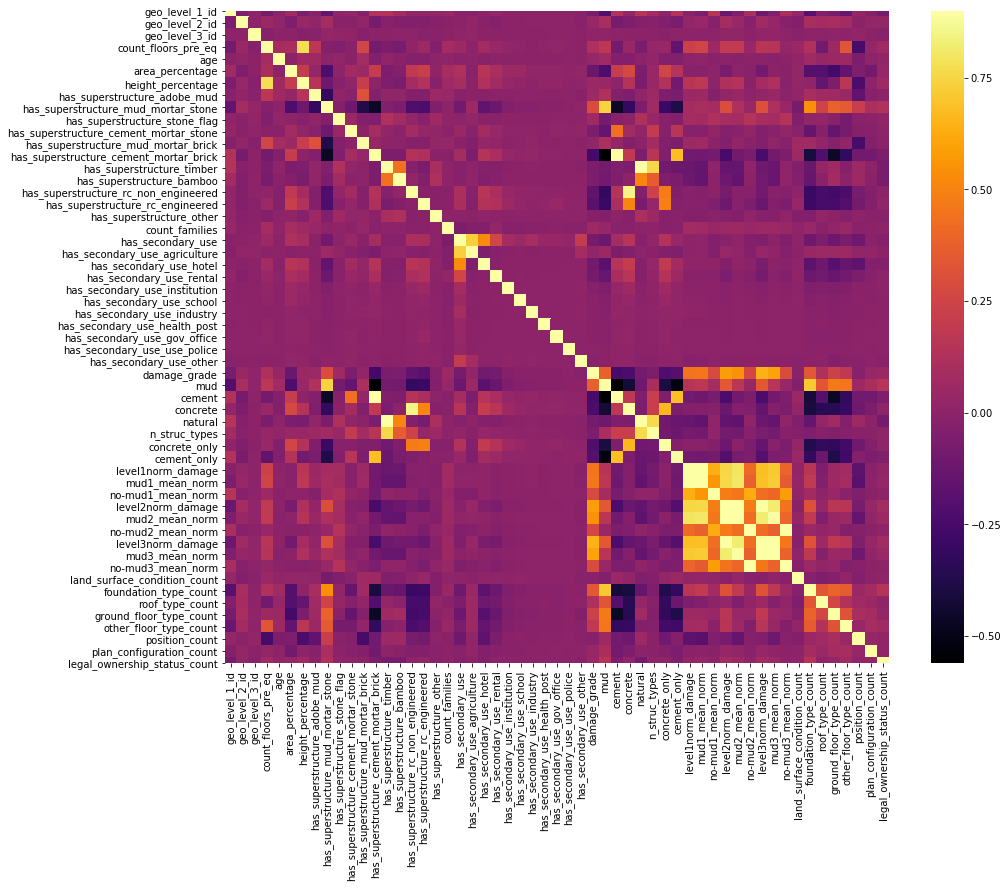

In [25]:
corr = test_and_train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="inferno", square=True)

Text(0.5, 1.0, 'Correlation of the features with damage grade')

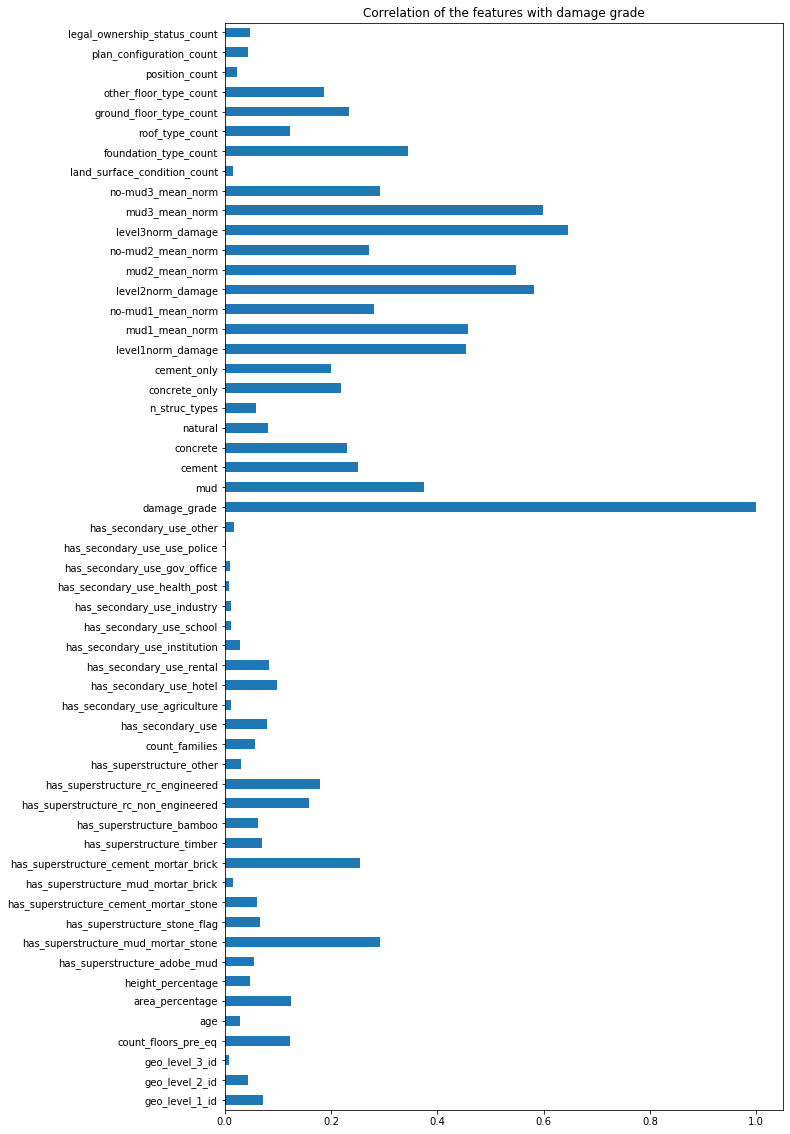

In [26]:
#Correlation with output variable
cor_target = abs(corr["damage_grade"])

cor_target.plot(kind='barh',figsize=(10,20))
plt.title("Correlation of the features with damage grade")

In [27]:
test_and_train["age_l"] = np.log1p(test_and_train["age"])
test_and_train["age_l"] = test_and_train["age_l"].round(decimals=0)
test_and_train["area_pc"] = np.log1p(test_and_train["area_percentage"])
test_and_train["area_pc"] = test_and_train["area_pc"].round(decimals=1)
test_and_train["height_pc"] = np.log1p(test_and_train["height_percentage"])
test_and_train["height_pc"] = test_and_train["height_pc"].round(decimals=1)

In [28]:
train_ex_geo = test_and_train.loc[train_index].drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)
#train_ex_geo = test_and_train.loc[train_index].drop(['geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_ex_geo, test_and_train.loc[train_index,'damage_grade'], test_size=0.05)


In [29]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

array([3.45908259, 0.58585773, 0.99600904])

In [30]:
cols_to_use = [
    'level1norm_damage',
    'mud1_mean_norm',
    'no-mud1_mean_norm',
    'level2norm_damage',
    'mud2_mean_norm',
    'no-mud2_mean_norm',
    'level3norm_damage',
    'mud3_mean_norm',
    'no-mud3_mean_norm',
    'mud',
    'cement_only',
    'concrete_only',
    'count_floors_pre_eq',
    'age_l',
    'area_pc',
    'height_pc',
    'foundation_type_target',
    'ground_floor_type_target',
    'other_floor_type_target',
    'roof_type_target'
]


In [31]:
filter_col = []
for col_prefix in cols_to_use:
    filter_col.extend([col for col in X_train if col.startswith(col_prefix)])

#It's possible to get repeats here, so I'll clean up after the fact. Should start with set instead to avoid the issue.
filter_col = list(set(filter_col))

In [32]:
train_ex_geo = test_and_train.loc[train_index].drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)
#train_ex_geo = test_and_train.loc[train_index].drop(['geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(train_ex_geo, test_and_train.loc[train_index,'damage_grade'], test_size=0.05)

clf_xgb = XGBClassifier(n_estimators=5000,gamma=0.7, learning_rate=0.1, max_depth=15,
                        min_child_weight=0, subsample=0.7, colsample_bytree=0.7,
                        scale_pos_weight=1, reg_alpha=0.00006)
eval_set = [(X_train, y_train-1), (X_test, y_test-1)]
clf_xgb.fit(X_train, y_train-1, eval_set=eval_set, verbose=True, early_stopping_rounds=25)

[0]	validation_0-merror:0.207893	validation_1-merror:0.258307
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 25 rounds.
[1]	validation_0-merror:0.200448	validation_1-merror:0.24764
[2]	validation_0-merror:0.19609	validation_1-merror:0.247026
[3]	validation_0-merror:0.193574	validation_1-merror:0.248561
[4]	validation_0-merror:0.191069	validation_1-merror:0.247257
[5]	validation_0-merror:0.189837	validation_1-merror:0.244187
[6]	validation_0-merror:0.189147	validation_1-merror:0.243957
[7]	validation_0-merror:0.187822	validation_1-merror:0.244494
[8]	validation_0-merror:0.186178	validation_1-merror:0.243189
[9]	validation_0-merror:0.185422	validation_1-merror:0.24365
[10]	validation_0-merror:0.184618	validation_1-merror:0.24365
[11]	validation_0-merror:0.183908	validation_1-merror:0.243343
[12]	validation_0-merror:0.182857	validation_1-merror:0.244494
[13]	validation_0-merror:0.18161

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.7,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=0, missing=None, n_estimators=20000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

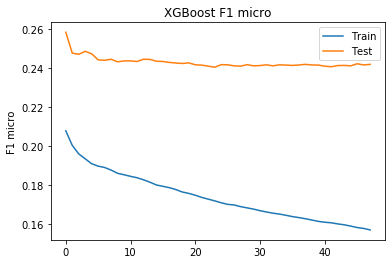

In [34]:
# retrieve performance metrics
results = clf_xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot f1 error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('F1 micro')
plt.title('XGBoost F1 micro')
plt.show()


In [39]:
y_pred = clf_xgb.predict(X_test)+1
f1_score(y_test, y_pred, average='micro')

0.7595733251477247

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         1.0       0.70      0.55      0.61      1232
         2.0       0.76      0.86      0.80      7432
         3.0       0.78      0.65      0.71      4367

    accuracy                           0.76     13031
   macro avg       0.74      0.69      0.71     13031
weighted avg       0.76      0.76      0.76     13031



In [37]:
y_pred = clf_xgb.predict(test_and_train.loc[test_index].drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1))

In [38]:
submission(y_pred+1)